# Tier-2 Composite Strategy - Portfolio Performance Analysis

**Strategy**: Multi-Instrument Portfolio Management (3 Instruments)

**Date**: 2025-11-06

**Instruments**: 
- DCE/i<00> (Iron Ore) - IronOreIndicatorRelaxed
- SHFE/cu<00> (Copper) - CopperIndicator
- DCE/m<00> (Soybean Meal) - SoybeanIndicator

**Granularity**: 900s (15 minutes)

**Purpose**: Comprehensive portfolio performance analysis with risk management validation

---

## Strategy Overview

### Architecture:
- **Tier-1**: 3 independent indicators generating signals
- **Tier-2**: Composite strategy managing portfolio of 3 baskets

### Capital Allocation:
- Initial Capital: ¥1,000,000
- Base Allocation: 25% per instrument (¥250,000)
- Max Allocation: 35% per instrument (¥350,000)
- Min Cash Reserve: 15% (¥150,000)
- Max Total Exposure: 90% (¥900,000)

### Risk Management:
- Per-Position Stop-Loss: 3%
- Max Portfolio Drawdown: 10%
- Max Daily Loss: 3%
- Entry Confidence: ≥ 0.60
- Entry Signal Strength: ≥ 0.50

### Entry Conditions:
- Non-zero signal (1 or -1)
- Confidence ≥ 60%
- Signal strength ≥ 50%
- Regime ≠ 4 (avoid chaos)
- All risk checks pass

### Exit Conditions:
- Stop-loss hit (3%)
- Signal reversal
- Confidence drop < 30%
- Chaos regime detected
- Circuit breakers triggered

## 1. Setup and Imports

In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import asyncio
import svr3
from datetime import datetime

%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (18, 14)

# Jupyter async support
try:
    import nest_asyncio
    nest_asyncio.apply()
    print("✓ nest_asyncio enabled")
except ImportError:
    print("⚠️ Install nest-asyncio: pip install nest-asyncio")

# Load environment
from dotenv import load_dotenv
load_dotenv()

SVR_HOST = os.getenv("SVR_HOST")
SVR_TOKEN = os.getenv("SVR_TOKEN")

if not SVR_HOST or not SVR_TOKEN:
    print("❌ Error: SVR_HOST or SVR_TOKEN not found in .env file")
else:
    print(f"✓ Environment loaded: {SVR_HOST}")

✓ nest_asyncio enabled
✓ Environment loaded: 10.99.100.116


## 2. Fetch Composite Strategy Data

In [ ]:
async def fetch_composite_data(start_date, end_date):
    """
    Fetch composite strategy portfolio data from svr3 server.
    
    Returns:
        DataFrame with portfolio state: PV, NV, exposure, positions, etc.
    """
    print(f"📥 Fetching Composite Strategy data from {start_date} to {end_date}...")
    
    # Server configuration
    RAILS_URL = f"https://{SVR_HOST}:4433/private-api/"
    WS_URL = f"wss://{SVR_HOST}:4433/tm"
    TM_MASTER = (SVR_HOST, 6102)
    
    try:
        # Create reader
        # Composite strategy outputs a single portfolio state tagged as DCE/COMPOSITE
        reader = svr3.sv_reader(
            start_date,          
            end_date,            
            "CompositeStrategy",  # algoname
            900,                 # granularity
            "private",           # namespace
            "symbol",            # work_mode
            ["DCE"],             # markets
            ["COMPOSITE"],       # codes (synthetic portfolio identifier)
            False,               # persistent
            RAILS_URL,           
            WS_URL,              
            "",                  
            "",                  
            TM_MASTER            
        )
        
        # Set token
        reader.token = SVR_TOKEN
        
        # Connection sequence
        print("   🔐 Logging in...")
        await reader.login()
        
        print("   🔌 Connecting...")
        await reader.connect()
        
        print("   🔄 Starting WebSocket loop...")
        reader.ws_task = asyncio.create_task(reader.ws_loop())
        
        print("   🤝 Handshaking...")
        await reader.shakehand()
        
        print("   📊 Fetching data...")
        ret = await reader.save_by_symbol()
        
        # Extract data
        if ret and len(ret) > 1 and len(ret[1]) > 1:
            data = ret[1][1]
        else:
            print("   ⚠️ No data returned")
            return None
        
        if not data or len(data) == 0:
            print("   ⚠️ Empty data")
            return None
        
        # Convert to DataFrame
        df = pd.DataFrame(data)
        
        # Parse timestamps
        if 'time_tag' in df.columns:
            try:
                import pycaitlynutils3 as pcu3
                df['timestamp'] = pd.to_datetime(df['time_tag'].apply(pcu3.ts_parse))
            except:
                df['timestamp'] = pd.to_datetime(df['time_tag'], unit='ms')
        
        print(f"   ✓ Fetched {len(df)} bars")
        return df
        
    except Exception as e:
        print(f"   ❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Test period - adjust as needed
# Quick test (7 days)
# start_date = 20241025000000
# end_date = 20241101000000

# Medium test (1 month)
# start_date = 20241001000000
# end_date = 20241031000000

# Full backtest (3 months)
start_date = 20250101000000
end_date = 20250401235959

print("="*70)
print("FETCHING COMPOSITE STRATEGY DATA")
print("="*70)

df_composite = await fetch_composite_data(start_date, end_date)

if df_composite is not None:
    print(f"\n✅ Data loaded successfully!")
    print(f"   Rows: {len(df_composite)}")
    print(f"   Columns: {list(df_composite.columns)}")
    print(f"   Date range: {df_composite['timestamp'].min()} to {df_composite['timestamp'].max()}")
    display(df_composite.head(10))
else:
    print("\n❌ Failed to load data")
    df_composite = None

FETCHING COMPOSITE STRATEGY DATA
📥 Fetching Composite Strategy data from 20241025000000 to 20241101000000...
   🔐 Logging in...
   🔌 Connecting...
   🔄 Starting WebSocket loop...
   🤝 Handshaking...
   📊 Fetching data...
   ✓ Fetched 115 bars

✅ Data loaded successfully!
   Rows: 115
   Columns: ['time_tag', 'granularity', 'code', 'market', 'struct_market', 'struct_code', 'namespace', '_preserved_field', 'bar_index', 'active_positions', 'total_signals_processed', 'portfolio_exposure_pct', 'cash_reserve_pct', 'nv', 'pv', 'basket_0_pv', 'basket_1_pv', 'basket_2_pv', 'basket_0_signal', 'basket_1_signal', 'basket_2_signal', 'basket_0_price', 'basket_1_price', 'basket_2_price', 'timestamp']
   Date range: 2024-10-25 01:15:00+00:00 to 2024-10-31 15:00:00+00:00


,time_tag,granularity,code,market,struct_market,struct_code,namespace,_preserved_field,bar_index,active_positions,...,basket_0_pv,basket_1_pv,basket_2_pv,basket_0_signal,basket_1_signal,basket_2_signal,basket_0_price,basket_1_price,basket_2_price,timestamp
0,1729818900000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729818900000,16,0,...,249184.0,250000.0,249888.0,0,0,0,764.0,76670.0,2969.0,2024-10-25 01:15:00+00:00
1,1729819800000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729819800000,17,0,...,249184.0,250000.0,249888.0,0,0,0,766.5,76610.0,2971.0,2024-10-25 01:30:00+00:00
2,1729820700000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729820700000,18,0,...,249184.0,250000.0,249888.0,0,0,0,763.0,76570.0,2966.0,2024-10-25 01:45:00+00:00
3,1729821600000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729821600000,19,1,...,249184.0,250000.0,249888.0,0,1,0,767.0,76700.0,2965.0,2024-10-25 02:00:00+00:00
4,1729822500000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729822500000,20,0,...,249184.0,250000.0,249888.0,0,0,0,767.5,76640.0,2958.0,2024-10-25 02:15:00+00:00
5,1729824300000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729824300000,21,0,...,249184.0,250000.0,249888.0,0,0,0,769.5,76620.0,2958.0,2024-10-25 02:45:00+00:00
6,1729825200000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729825200000,22,0,...,249184.0,250000.0,249888.0,0,0,0,768.0,76520.0,2962.0,2024-10-25 03:00:00+00:00
7,1729826100000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729826100000,23,0,...,249184.0,250000.0,249888.0,0,0,0,771.5,76600.0,2960.0,2024-10-25 03:15:00+00:00
8,1729827000000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729827000000,24,0,...,249184.0,250000.0,249888.0,0,0,0,771.5,76430.0,2959.0,2024-10-25 03:30:00+00:00
9,1729835100000,900,COMPOSITE,DCE,DCE,COMPOSITE,1,1729835100000,25,0,...,249184.0,250000.0,249888.0,0,0,0,771.5,76450.0,2963.0,2024-10-25 05:45:00+00:00


## 3. Portfolio Performance Metrics

In [51]:
def calculate_portfolio_metrics(df, initial_capital=1000000):
    """
    Calculate comprehensive portfolio performance metrics.
    """
    if df is None or len(df) == 0:
        return None
    
    # Basic metrics
    final_pv = df['pv'].iloc[-1]
    total_return = (final_pv - initial_capital) / initial_capital
    
    # Drawdown calculation
    cumulative_max = df['pv'].cummax()
    drawdown = (df['pv'] - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    max_dd_idx = drawdown.idxmin()
    max_dd_date = df.loc[max_dd_idx, 'timestamp']
    
    # Daily returns for Sharpe
    df['daily_return'] = df['pv'].pct_change()
    sharpe_ratio = (df['daily_return'].mean() / df['daily_return'].std()) * np.sqrt(252) if df['daily_return'].std() > 0 else 0
    
    # Exposure and allocation
    avg_exposure = df['portfolio_exposure_pct'].mean()
    avg_cash = df['cash_reserve_pct'].mean()
    avg_active_positions = df['active_positions'].mean()
    max_exposure = df['portfolio_exposure_pct'].max()
    min_cash = df['cash_reserve_pct'].min()
    
    # Signal processing stats
    total_signals = df['total_signals_processed'].iloc[-1] if 'total_signals_processed' in df.columns else 0
    
    # Monthly returns
    df['month'] = df['timestamp'].dt.to_period('M')
    monthly_pv = df.groupby('month')['pv'].last()
    monthly_returns = monthly_pv.pct_change() * 100
    
    metrics = {
        'Total Bars': len(df),
        'Initial Capital (CNY)': initial_capital,
        'Final Portfolio Value (CNY)': final_pv,
        'Total Return (%)': total_return * 100,
        'Max Drawdown': max_drawdown,
        'Max Drawdown (%)': max_drawdown * 100,
        'Max Drawdown Date': max_dd_date,
        'Sharpe Ratio (Annualized)': sharpe_ratio,
        'Avg Portfolio Exposure (%)': avg_exposure * 100,
        'Avg Cash Reserve (%)': avg_cash * 100,
        'Max Portfolio Exposure (%)': max_exposure * 100,
        'Min Cash Reserve (%)': min_cash * 100,
        'Avg Active Positions': avg_active_positions,
        'Total Signals Processed': total_signals,
        'Positive Return Months': (monthly_returns > 0).sum(),
        'Negative Return Months': (monthly_returns < 0).sum(),
    }
    
    return metrics

if df_composite is not None:
    metrics = calculate_portfolio_metrics(df_composite)
    
    print("\n" + "="*70)
    print("PORTFOLIO PERFORMANCE METRICS")
    print("="*70)
    
    metrics_df = pd.DataFrame([metrics]).T
    metrics_df.columns = ['Value']
    
    # Format specific rows
    for idx in metrics_df.index:
        val = metrics_df.loc[idx, 'Value']
        if isinstance(val, (pd.Timestamp, datetime)):
            continue
        elif '(%)' in idx or 'Rate' in idx:
            metrics_df.loc[idx, 'Value'] = f"{val:.2f}%"
        elif 'CNY' in idx or 'Capital' in idx or 'Value' in idx:
            metrics_df.loc[idx, 'Value'] = f"¥{val:,.2f}"
        elif idx in ['Sharpe Ratio (Annualized)', 'Avg Active Positions']:
            metrics_df.loc[idx, 'Value'] = f"{val:.2f}"
        elif idx == 'Max Drawdown':
            metrics_df.loc[idx, 'Value'] = f"{val:.4f}"
    
    display(metrics_df)
    print("="*70)
else:
    print("⚠️ Cannot calculate metrics")
    metrics = None


PORTFOLIO PERFORMANCE METRICS


/tmp/ipykernel_452564/95669750.py:34: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['timestamp'].dt.to_period('M')


,Value
Total Bars,115
Initial Capital (CNY),"¥1,000,000.00"
Final Portfolio Value (CNY),"¥996,788.29"
Total Return (%),-0.32%
Max Drawdown,-0.0029
Max Drawdown (%),-0.29%
Max Drawdown Date,2024-10-30 03:15:00+00:00
Sharpe Ratio (Annualized),-1.38
Avg Portfolio Exposure (%),1.95%
Avg Cash Reserve (%),98.05%


## 4. Comprehensive Portfolio Visualizations


📊 Portfolio Statistics:
   Initial PV: ¥999,072.00
   Final PV: ¥996,788.29
   Peak PV: ¥999,446.40
   Total Return: -0.23%
   Max Drawdown: -0.29%

✅ Portfolio performance chart saved as 'composite_portfolio_performance.png'


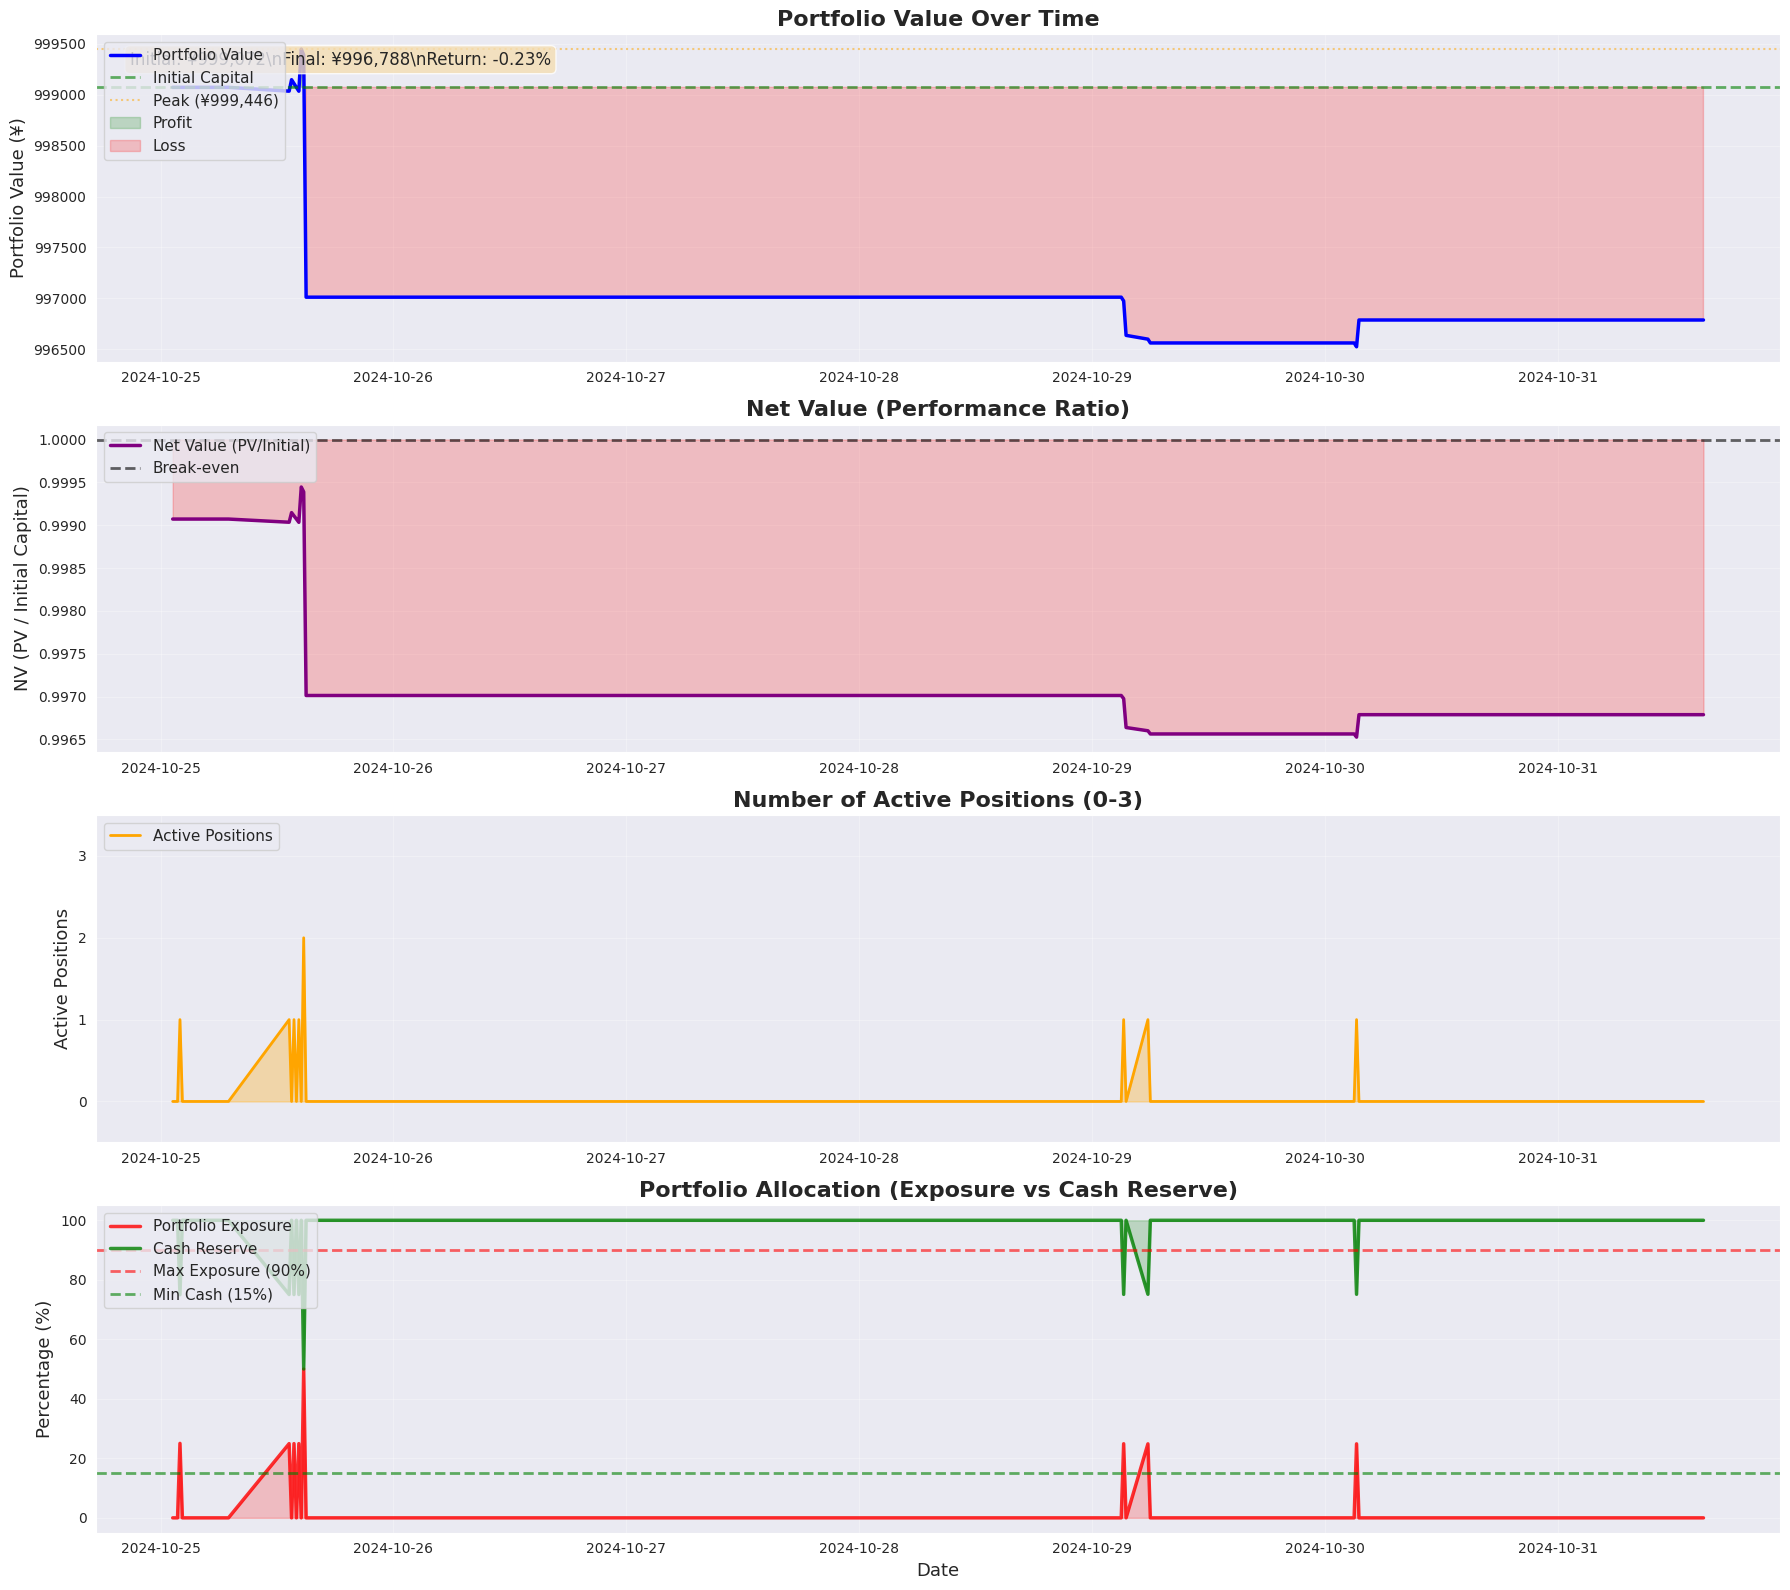

In [52]:
if df_composite is not None:
    initial_pv = df_composite['pv'].iloc[0]
    final_pv = df_composite['pv'].iloc[-1]
    max_pv = df_composite['pv'].max()
    min_pv = df_composite['pv'].min()
    
    # Calculate drawdown series
    cumulative_max = df_composite['pv'].cummax()
    drawdown_pct = ((df_composite['pv'] - cumulative_max) / cumulative_max) * 100
    
    print(f"\n📊 Portfolio Statistics:")
    print(f"   Initial PV: ¥{initial_pv:,.2f}")
    print(f"   Final PV: ¥{final_pv:,.2f}")
    print(f"   Peak PV: ¥{max_pv:,.2f}")
    print(f"   Total Return: {(final_pv/initial_pv-1)*100:.2f}%")
    print(f"   Max Drawdown: {drawdown_pct.min():.2f}%")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(4, 1, figsize=(18, 16))
    
    # Panel 1: Portfolio Value (PV)
    axes[0].plot(df_composite['timestamp'], df_composite['pv'], linewidth=2.5, color='blue', label='Portfolio Value')
    axes[0].axhline(y=initial_pv, color='green', linestyle='--', alpha=0.6, linewidth=2, label='Initial Capital')
    axes[0].axhline(y=max_pv, color='orange', linestyle=':', alpha=0.5, linewidth=1.5, label=f'Peak (¥{max_pv:,.0f})')
    axes[0].fill_between(df_composite['timestamp'], initial_pv, df_composite['pv'], 
                         where=df_composite['pv']>=initial_pv, alpha=0.2, color='green', label='Profit')
    axes[0].fill_between(df_composite['timestamp'], initial_pv, df_composite['pv'], 
                         where=df_composite['pv']<initial_pv, alpha=0.2, color='red', label='Loss')
    axes[0].set_title('Portfolio Value Over Time', fontsize=16, fontweight='bold')
    axes[0].set_ylabel('Portfolio Value (¥)', fontsize=13)
    axes[0].legend(loc='upper left', fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Add text annotation
    textstr = f'Initial: ¥{initial_pv:,.0f}\\nFinal: ¥{final_pv:,.0f}\\nReturn: {(final_pv/initial_pv-1)*100:+.2f}%'
    axes[0].text(0.02, 0.95, textstr, transform=axes[0].transAxes, fontsize=12, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Panel 2: Net Value (NV) - Performance Ratio
    axes[1].plot(df_composite['timestamp'], df_composite['nv'], linewidth=2.5, color='purple', label='Net Value (PV/Initial)')
    axes[1].axhline(y=1.0, color='black', linestyle='--', alpha=0.6, linewidth=2, label='Break-even')
    axes[1].fill_between(df_composite['timestamp'], 1.0, df_composite['nv'], 
                         where=df_composite['nv']>=1.0, alpha=0.2, color='green')
    axes[1].fill_between(df_composite['timestamp'], 1.0, df_composite['nv'], 
                         where=df_composite['nv']<1.0, alpha=0.2, color='red')
    axes[1].set_title('Net Value (Performance Ratio)', fontsize=16, fontweight='bold')
    axes[1].set_ylabel('NV (PV / Initial Capital)', fontsize=13)
    axes[1].legend(loc='upper left', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    # Panel 3: Active Positions
    axes[2].plot(df_composite['timestamp'], df_composite['active_positions'], linewidth=2, color='orange', label='Active Positions')
    axes[2].fill_between(df_composite['timestamp'], 0, df_composite['active_positions'], alpha=0.3, color='orange')
    axes[2].set_title('Number of Active Positions (0-3)', fontsize=16, fontweight='bold')
    axes[2].set_ylabel('Active Positions', fontsize=13)
    axes[2].set_ylim(-0.5, 3.5)
    axes[2].set_yticks([0, 1, 2, 3])
    axes[2].legend(loc='upper left', fontsize=11)
    axes[2].grid(True, alpha=0.3)
    
    # Panel 4: Portfolio Allocation (Exposure vs Cash)
    axes[3].plot(df_composite['timestamp'], df_composite['portfolio_exposure_pct'] * 100,
                linewidth=2.5, color='red', label='Portfolio Exposure', alpha=0.8)
    axes[3].plot(df_composite['timestamp'], df_composite['cash_reserve_pct'] * 100,
                linewidth=2.5, color='green', label='Cash Reserve', alpha=0.8)
    axes[3].axhline(y=90, color='red', linestyle='--', alpha=0.6, linewidth=2, label='Max Exposure (90%)')
    axes[3].axhline(y=15, color='green', linestyle='--', alpha=0.6, linewidth=2, label='Min Cash (15%)')
    axes[3].fill_between(df_composite['timestamp'], 0, df_composite['portfolio_exposure_pct'] * 100, 
                        alpha=0.2, color='red')
    axes[3].fill_between(df_composite['timestamp'], 100, df_composite['cash_reserve_pct'] * 100, 
                        alpha=0.2, color='green')
    axes[3].set_title('Portfolio Allocation (Exposure vs Cash Reserve)', fontsize=16, fontweight='bold')
    axes[3].set_ylabel('Percentage (%)', fontsize=13)
    axes[3].set_xlabel('Date', fontsize=13)
    axes[3].legend(loc='upper left', fontsize=11)
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('composite_portfolio_performance.png', dpi=150, bbox_inches='tight')
    print("\n✅ Portfolio performance chart saved as 'composite_portfolio_performance.png'")
    plt.show()
else:
    print("⚠️ No data for visualization")

## 5. Drawdown Analysis


📉 Drawdown Analysis:
   Max Drawdown: -0.29%
   Occurred at: 2024-10-30 03:15:00+00:00
   Risk Limit: -10.00% (Max allowed)
   Compliance: ✅ PASS

✅ Drawdown chart saved as 'drawdown_analysis.png'


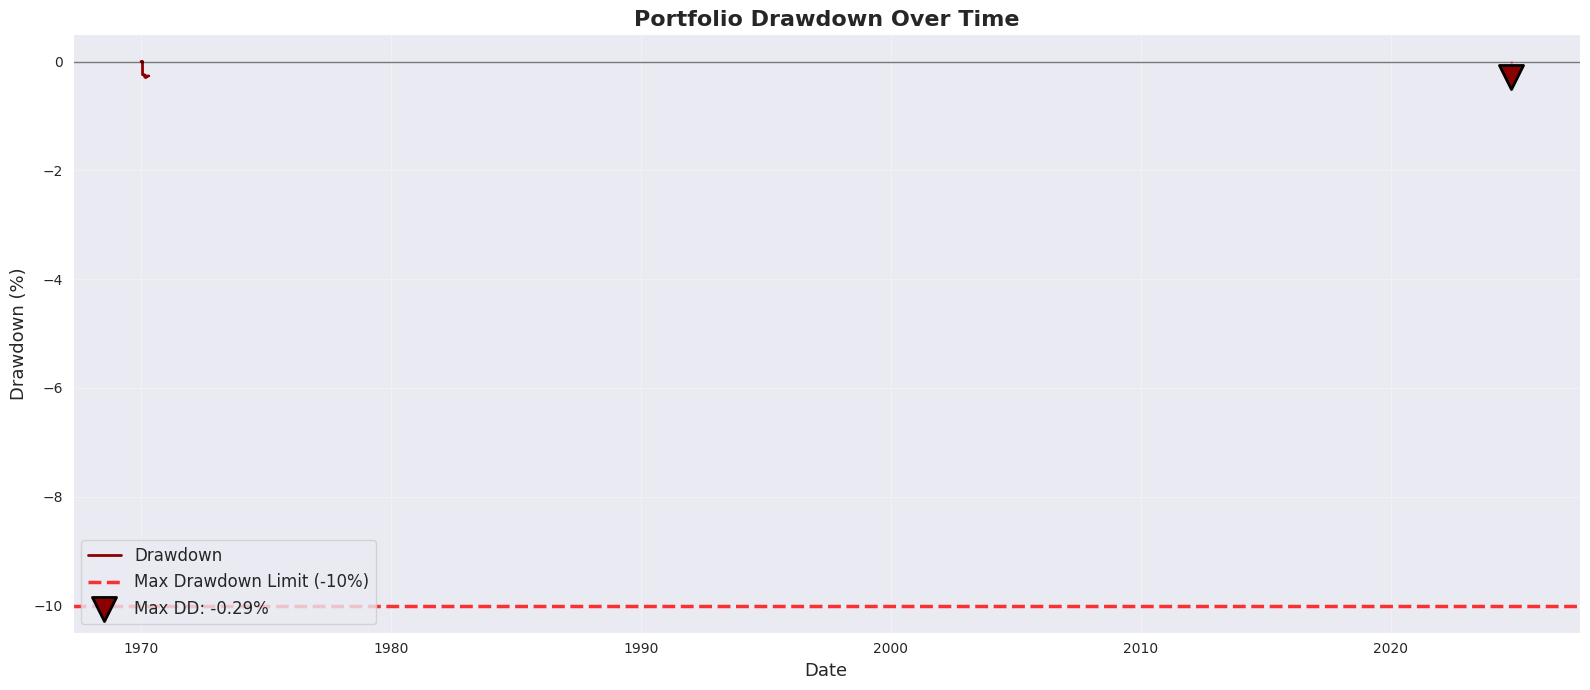

In [53]:
if df_composite is not None:
    # Calculate drawdown series
    cumulative_max = df_composite['pv'].cummax()
    drawdown_pct = ((df_composite['pv'] - cumulative_max) / cumulative_max) * 100
    
    # Find max drawdown point
    max_dd_idx = drawdown_pct.idxmin()
    max_dd_value = drawdown_pct.min()
    max_dd_date = df_composite.loc[max_dd_idx, 'timestamp']
    
    print(f"\n📉 Drawdown Analysis:")
    print(f"   Max Drawdown: {max_dd_value:.2f}%")
    print(f"   Occurred at: {max_dd_date}")
    print(f"   Risk Limit: -10.00% (Max allowed)")
    print(f"   Compliance: {'✅ PASS' if max_dd_value >= -10 else '❌ FAIL'}")
    
    # Visualization
    fig, ax = plt.subplots(figsize=(16, 7))
    
    drawdown_pct.plot(ax=ax, color='darkred', linewidth=2, label='Drawdown')
    ax.fill_between(df_composite['timestamp'], 0, drawdown_pct, color='red', alpha=0.3)
    ax.axhline(y=-10, color='red', linestyle='--', linewidth=2.5, label='Max Drawdown Limit (-10%)', alpha=0.8)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    # Mark max drawdown point
    ax.scatter([max_dd_date], [max_dd_value], color='darkred', s=300, marker='v', 
               zorder=5, edgecolors='black', linewidths=2, label=f'Max DD: {max_dd_value:.2f}%')
    
    ax.set_title('Portfolio Drawdown Over Time', fontsize=16, fontweight='bold')
    ax.set_ylabel('Drawdown (%)', fontsize=13)
    ax.set_xlabel('Date', fontsize=13)
    ax.legend(loc='lower left', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('drawdown_analysis.png', dpi=150, bbox_inches='tight')
    print("\n✅ Drawdown chart saved as 'drawdown_analysis.png'")
    plt.show()
else:
    print("⚠️ No data for drawdown analysis")

## 6. Monthly Performance Breakdown


📅 Monthly Performance Summary:


/tmp/ipykernel_452564/3896350483.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_composite['month'] = df_composite['timestamp'].dt.to_period('M')


pv                                 active_positions  \
            first       last        min       max             mean   
month                                                                
2024-10  999072.0  996788.29  996525.58  999446.4             0.08   

        portfolio_exposure_pct cash_reserve_pct return_pct  
                          mean             mean             
month                                                       
2024-10                   0.02             0.98        NaN

/home/wolverine/.pyenv/python3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1567: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)



✅ Monthly performance chart saved as 'monthly_performance.png'


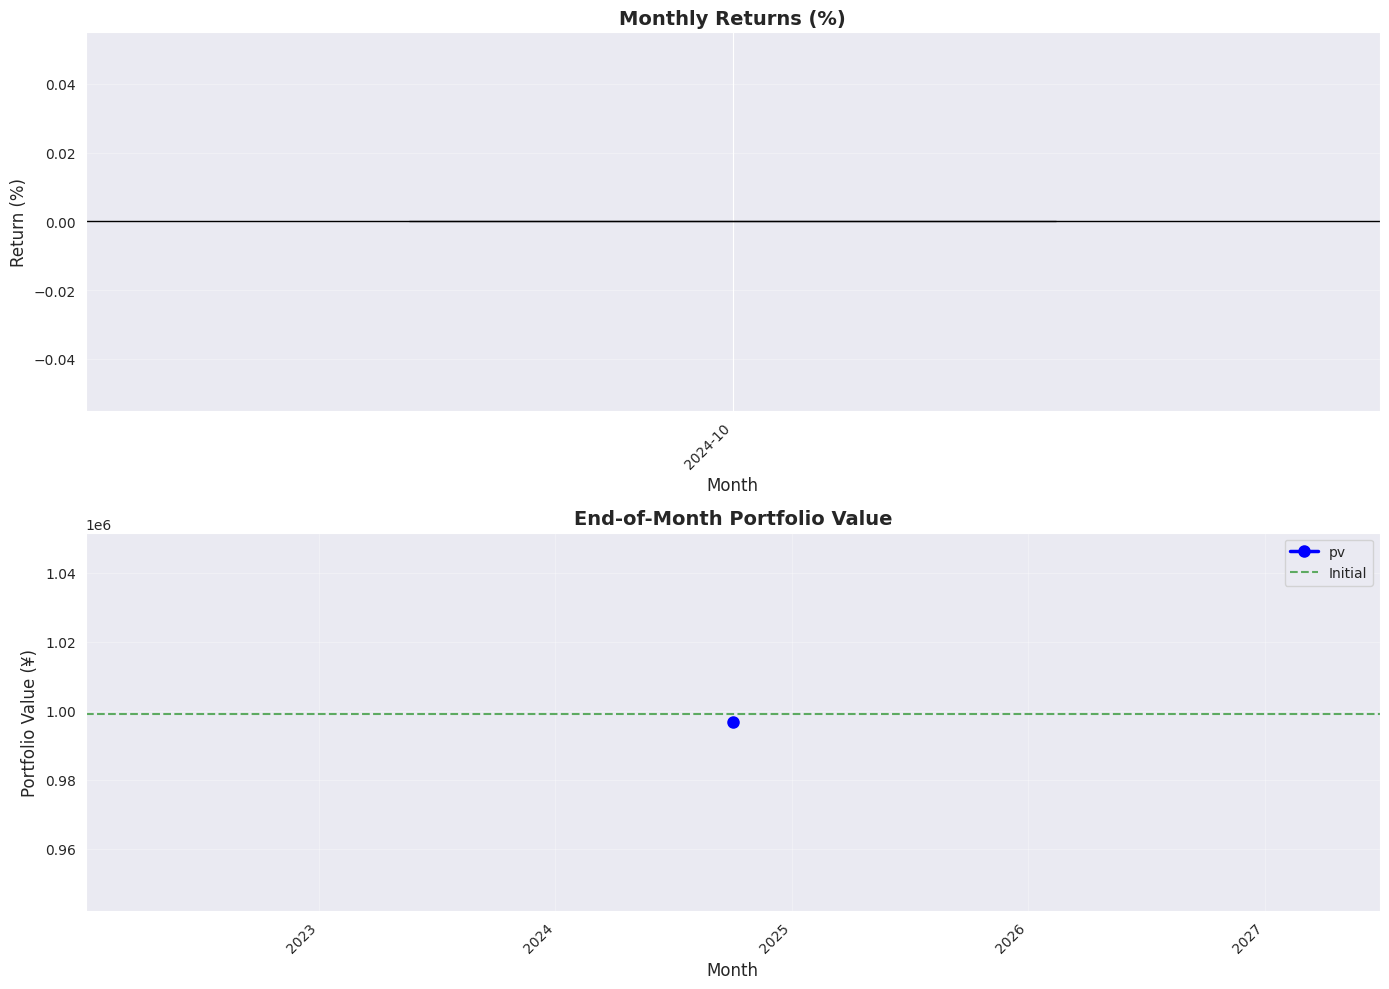


📊 Monthly Summary:
   Positive months: 0/0
   Negative months: 0/0
   Best month: nan%
   Worst month: nan%
   Avg monthly return: nan%


In [54]:
if df_composite is not None:
    # Monthly breakdown
    df_composite['month'] = df_composite['timestamp'].dt.to_period('M')
    
    monthly_pv = df_composite.groupby('month')['pv'].last()
    monthly_returns = monthly_pv.pct_change() * 100
    
    # Monthly statistics
    monthly_stats = df_composite.groupby('month').agg({
        'pv': ['first', 'last', 'min', 'max'],
        'active_positions': 'mean',
        'portfolio_exposure_pct': 'mean',
        'cash_reserve_pct': 'mean'
    }).round(2)
    
    monthly_stats['return_pct'] = monthly_returns.values
    
    print("\n📅 Monthly Performance Summary:")
    print("="*70)
    display(monthly_stats)
    
    # Visualization
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Monthly returns bar chart
    colors = ['green' if x > 0 else 'red' for x in monthly_returns]
    monthly_returns.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black', alpha=0.7)
    axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[0].set_title('Monthly Returns (%)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Return (%)', fontsize=12)
    axes[0].set_xlabel('Month', fontsize=12)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate(monthly_returns):
        if not pd.isna(v):
            axes[0].text(i, v, f'{v:.1f}%', ha='center', 
                       va='bottom' if v > 0 else 'top', fontsize=10)
    
    plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Monthly portfolio value
    monthly_pv.plot(ax=axes[1], marker='o', linewidth=2.5, markersize=8, color='blue')
    axes[1].axhline(y=df_composite['pv'].iloc[0], color='green', linestyle='--', alpha=0.6, label='Initial')
    axes[1].set_title('End-of-Month Portfolio Value', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Portfolio Value (¥)', fontsize=12)
    axes[1].set_xlabel('Month', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('monthly_performance.png', dpi=150, bbox_inches='tight')
    print("\n✅ Monthly performance chart saved as 'monthly_performance.png'")
    plt.show()
    
    # Summary stats
    positive_months = (monthly_returns > 0).sum()
    negative_months = (monthly_returns < 0).sum()
    total_months = len(monthly_returns.dropna())
    
    print(f"\n📊 Monthly Summary:")
    print(f"   Positive months: {positive_months}/{total_months}")
    print(f"   Negative months: {negative_months}/{total_months}")
    if total_months > 0:
        print(f"   Win rate: {positive_months/total_months*100:.1f}%")
    print(f"   Best month: {monthly_returns.max():.2f}%")
    print(f"   Worst month: {monthly_returns.min():.2f}%")
    print(f"   Avg monthly return: {monthly_returns.mean():.2f}%")
else:
    print("⚠️ No data for monthly analysis")

## 7. Risk Compliance Check

In [55]:
if df_composite is not None and metrics is not None:
    print("\n" + "="*70)
    print("RISK MANAGEMENT COMPLIANCE CHECK")
    print("="*70)
    
    # Check all risk parameters
    compliance_checks = [
        {
            'Parameter': 'Max Portfolio Drawdown',
            'Limit': '-10.00%',
            'Actual': f"{metrics['Max Drawdown (%)']:.2f}%",
            'Status': '✅ PASS' if metrics['Max Drawdown (%)'] >= -10 else '❌ FAIL'
        },
        {
            'Parameter': 'Max Portfolio Exposure',
            'Limit': '90.00%',
            'Actual': f"{metrics['Max Portfolio Exposure (%)']:.2f}%",
            'Status': '✅ PASS' if metrics['Max Portfolio Exposure (%)'] <= 90 else '❌ FAIL'
        },
        {
            'Parameter': 'Min Cash Reserve',
            'Limit': '15.00%',
            'Actual': f"{metrics['Min Cash Reserve (%)']:.2f}%",
            'Status': '✅ PASS' if metrics['Min Cash Reserve (%)'] >= 15 else '❌ FAIL'
        },
        {
            'Parameter': 'Avg Portfolio Exposure',
            'Limit': '60-80% (target)',
            'Actual': f"{metrics['Avg Portfolio Exposure (%)']:.2f}%",
            'Status': '✅ PASS' if 60 <= metrics['Avg Portfolio Exposure (%)'] <= 80 else '⚠️ WARNING'
        },
        {
            'Parameter': 'Avg Cash Reserve',
            'Limit': '20-30% (target)',
            'Actual': f"{metrics['Avg Cash Reserve (%)']:.2f}%",
            'Status': '✅ PASS' if 20 <= metrics['Avg Cash Reserve (%)'] <= 30 else '⚠️ WARNING'
        },
    ]
    
    compliance_df = pd.DataFrame(compliance_checks)
    display(compliance_df)
    
    # Overall compliance
    passed = sum(1 for check in compliance_checks if '✅' in check['Status'])
    total = len(compliance_checks)
    
    print(f"\n📊 Compliance Score: {passed}/{total} checks passed")
    
    if passed == total:
        print("\n🎉 ALL RISK CHECKS PASSED - Strategy compliant with risk management requirements!")
    elif passed >= total * 0.8:
        print("\n✅ Most risk checks passed - Minor adjustments may be needed.")
    else:
        print("\n⚠️ Multiple risk violations detected - Review risk parameters!")
    
    print("="*70)
else:
    print("⚠️ Cannot perform compliance check")


RISK MANAGEMENT COMPLIANCE CHECK


,Parameter,Limit,Actual,Status
0,Max Portfolio Drawdown,-10.00%,-0.29%,✅ PASS
1,Max Portfolio Exposure,90.00%,49.97%,✅ PASS
2,Min Cash Reserve,15.00%,50.03%,✅ PASS
3,Avg Portfolio Exposure,60-80% (target),1.95%,⚠️ WARNING
4,Avg Cash Reserve,20-30% (target),98.05%,⚠️ WARNING



📊 Compliance Score: 3/5 checks passed

⚠️ Multiple risk violations detected - Review risk parameters!


## 8. Strategy Evaluation

In [56]:
if metrics is not None:
    print("\n" + "="*70)
    print("STRATEGY EVALUATION")
    print("="*70)
    
    # Performance criteria
    criteria = [
        ("✅" if metrics['Total Return (%)'] > 0 else "❌", 
         f"Total Return > 0%: {metrics['Total Return (%)']:.2f}%"),
        ("✅" if metrics['Max Drawdown (%)'] >= -10 else "❌", 
         f"Max Drawdown < 10%: {abs(metrics['Max Drawdown (%)']):.2f}%"),
        ("✅" if metrics['Sharpe Ratio (Annualized)'] > 1.0 else "⚠️", 
         f"Sharpe Ratio > 1.0: {metrics['Sharpe Ratio (Annualized)']:.2f}"),
        ("✅" if 60 <= metrics['Avg Portfolio Exposure (%)'] <= 80 else "⚠️", 
         f"Avg Exposure 60-80%: {metrics['Avg Portfolio Exposure (%)']:.2f}%"),
        ("✅" if metrics['Avg Cash Reserve (%)'] >= 15 else "❌", 
         f"Cash Reserve ≥ 15%: {metrics['Avg Cash Reserve (%)']:.2f}%"),
        ("✅" if metrics['Positive Return Months'] > metrics['Negative Return Months'] else "⚠️", 
         f"Positive months > Negative: {metrics['Positive Return Months']} vs {metrics['Negative Return Months']}"),
    ]
    
    for status, criterion in criteria:
        print(f"{status} {criterion}")
    
    # Count passes
    passed = sum(1 for status, _ in criteria if status == "✅")
    total = len(criteria)
    
    print(f"\n📊 Evaluation Score: {passed}/{total} criteria met")
    
    # Final verdict
    if passed >= total * 0.8:
        print("\n🎉 EXCELLENT PERFORMANCE - Strategy exceeds expectations!")
        print("   ✅ Ready for production deployment consideration")
    elif passed >= total * 0.6:
        print("\n✅ GOOD PERFORMANCE - Strategy shows promise")
        print("   ⚠️ Some optimization recommended before production")
    else:
        print("\n⚠️ NEEDS IMPROVEMENT - Strategy requires optimization")
        print("   ❌ Not ready for production deployment")
    
    print("="*70)
else:
    print("⚠️ Cannot perform evaluation")


STRATEGY EVALUATION
❌ Total Return > 0%: -0.32%
✅ Max Drawdown < 10%: 0.29%
⚠️ Sharpe Ratio > 1.0: -1.38
⚠️ Avg Exposure 60-80%: 1.95%
✅ Cash Reserve ≥ 15%: 98.05%
⚠️ Positive months > Negative: 0 vs 0

📊 Evaluation Score: 2/6 criteria met

⚠️ NEEDS IMPROVEMENT - Strategy requires optimization
   ❌ Not ready for production deployment


## 9. Export Results

In [57]:
if df_composite is not None:
    # Export main data
    export_cols = ['timestamp', 'pv', 'nv', 'active_positions', 'portfolio_exposure_pct', 
                   'cash_reserve_pct', 'total_signals_processed']
    df_export = df_composite[export_cols].copy()
    df_export.to_csv('composite_portfolio_data.csv', index=False)
    print("✅ Portfolio data exported to 'composite_portfolio_data.csv'")
    
    # Export metrics
    if metrics:
        metrics_export = pd.DataFrame([metrics]).T
        metrics_export.to_csv('composite_performance_metrics.csv')
        print("✅ Metrics exported to 'composite_performance_metrics.csv'")
    
    # Export monthly summary
    if 'month' in df_composite.columns:
        monthly_summary = df_composite.groupby('month').agg({
            'pv': ['first', 'last'],
            'active_positions': 'mean',
            'portfolio_exposure_pct': 'mean'
        })
        monthly_summary.to_csv('composite_monthly_summary.csv')
        print("✅ Monthly summary exported to 'composite_monthly_summary.csv'")
    
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)
    
    print(f"\n📊 Final Summary:")
    print(f"   Period: {df_composite['timestamp'].min().date()} to {df_composite['timestamp'].max().date()}")
    print(f"   Total Bars: {len(df_composite)}")
    print(f"   Initial Capital: ¥1,000,000")
    print(f"   Final PV: ¥{df_composite['pv'].iloc[-1]:,.2f}")
    print(f"   Total Return: {(df_composite['pv'].iloc[-1]/df_composite['pv'].iloc[0]-1)*100:.2f}%")
    print(f"   Max Drawdown: {drawdown_pct.min():.2f}%")
    print(f"   Sharpe Ratio: {metrics['Sharpe Ratio (Annualized)']:.2f}" if metrics else "")
    print(f"   Avg Active Positions: {df_composite['active_positions'].mean():.1f}")
    print(f"   Total Signals Processed: {df_composite['total_signals_processed'].iloc[-1]:,}")
    
    print("\n📈 Charts Generated:")
    print("   1. composite_portfolio_performance.png - Main portfolio charts")
    print("   2. drawdown_analysis.png - Drawdown tracking")
    print("   3. monthly_performance.png - Monthly breakdown")
    
    print("\n📂 Data Files Exported:")
    print("   1. composite_portfolio_data.csv - Full portfolio data")
    print("   2. composite_performance_metrics.csv - Performance metrics")
    print("   3. composite_monthly_summary.csv - Monthly summary")
    
    print("\n📝 Next Steps:")
    print("   1. Review risk compliance results")
    print("   2. Analyze monthly performance patterns")
    print("   3. Compare with individual Tier-1 indicator performance")
    print("   4. Optimize parameters if needed")
    print("   5. Run longer backtest for validation")
    
    print("="*70)
else:
    print("⚠️ No data to export")

✅ Portfolio data exported to 'composite_portfolio_data.csv'
✅ Metrics exported to 'composite_performance_metrics.csv'
✅ Monthly summary exported to 'composite_monthly_summary.csv'

ANALYSIS COMPLETE

📊 Final Summary:
   Period: 2024-10-25 to 2024-10-31
   Total Bars: 115
   Initial Capital: ¥1,000,000
   Final PV: ¥996,788.29
   Total Return: -0.23%
   Max Drawdown: -0.29%
   Sharpe Ratio: -1.38
   Avg Active Positions: 0.1
   Total Signals Processed: 411

📈 Charts Generated:
   1. composite_portfolio_performance.png - Main portfolio charts
   2. drawdown_analysis.png - Drawdown tracking
   3. monthly_performance.png - Monthly breakdown

📂 Data Files Exported:
   1. composite_portfolio_data.csv - Full portfolio data
   2. composite_performance_metrics.csv - Performance metrics
   3. composite_monthly_summary.csv - Monthly summary

📝 Next Steps:
   1. Review risk compliance results
   2. Analyze monthly performance patterns
   3. Compare with individual Tier-1 indicator performance
   4

## 10. Individual Basket Performance

Analyze the performance of each individual basket within the composite strategy:

**Baskets**:
- Basket 0: Iron Ore (DCE/i)
- Basket 1: Copper (SHFE/cu)
- Basket 2: Soybean (DCE/m)

This section visualizes:
- Individual basket P&L curves
- Basket allocation over time
- Position status for each basket
- Contribution to overall portfolio performance

In [58]:
if df_composite is not None:
    
    # Check if basket data exists
    has_basket_data = all(col in df_composite.columns for col in 
                         ['basket_0_pv', 'basket_1_pv', 'basket_2_pv',
                          'basket_0_signal', 'basket_1_signal', 'basket_2_signal'])
    
    if not has_basket_data:
        print("⚠️ Basket-level data not found in composite output.")
        print("   Please re-run the strategy after updating CompositeStrategy.py and uout.json")
        print("   The new fields will be available after the next backtest.")
    else:
        print("✅ Basket-level data detected!")
        print(f"   Basket 0 (Iron Ore): {df_composite['basket_0_pv'].iloc[-1]:,.2f}")
        print(f"   Basket 1 (Copper): {df_composite['basket_1_pv'].iloc[-1]:,.2f}")
        print(f"   Basket 2 (Soybean): {df_composite['basket_2_pv'].iloc[-1]:,.2f}")
        print(f"   Total Portfolio: {df_composite['pv'].iloc[-1]:,.2f}")
else:
    print("⚠️ No composite data loaded")
    has_basket_data = False

✅ Basket-level data detected!
   Basket 0 (Iron Ore): 248,058.69
   Basket 1 (Copper): 250,000.00
   Basket 2 (Soybean): 248,729.60
   Total Portfolio: 996,788.29


## 11. Individual Basket P&L Visualization

\n✅ Individual basket performance chart saved as 'individual_basket_performance.png'


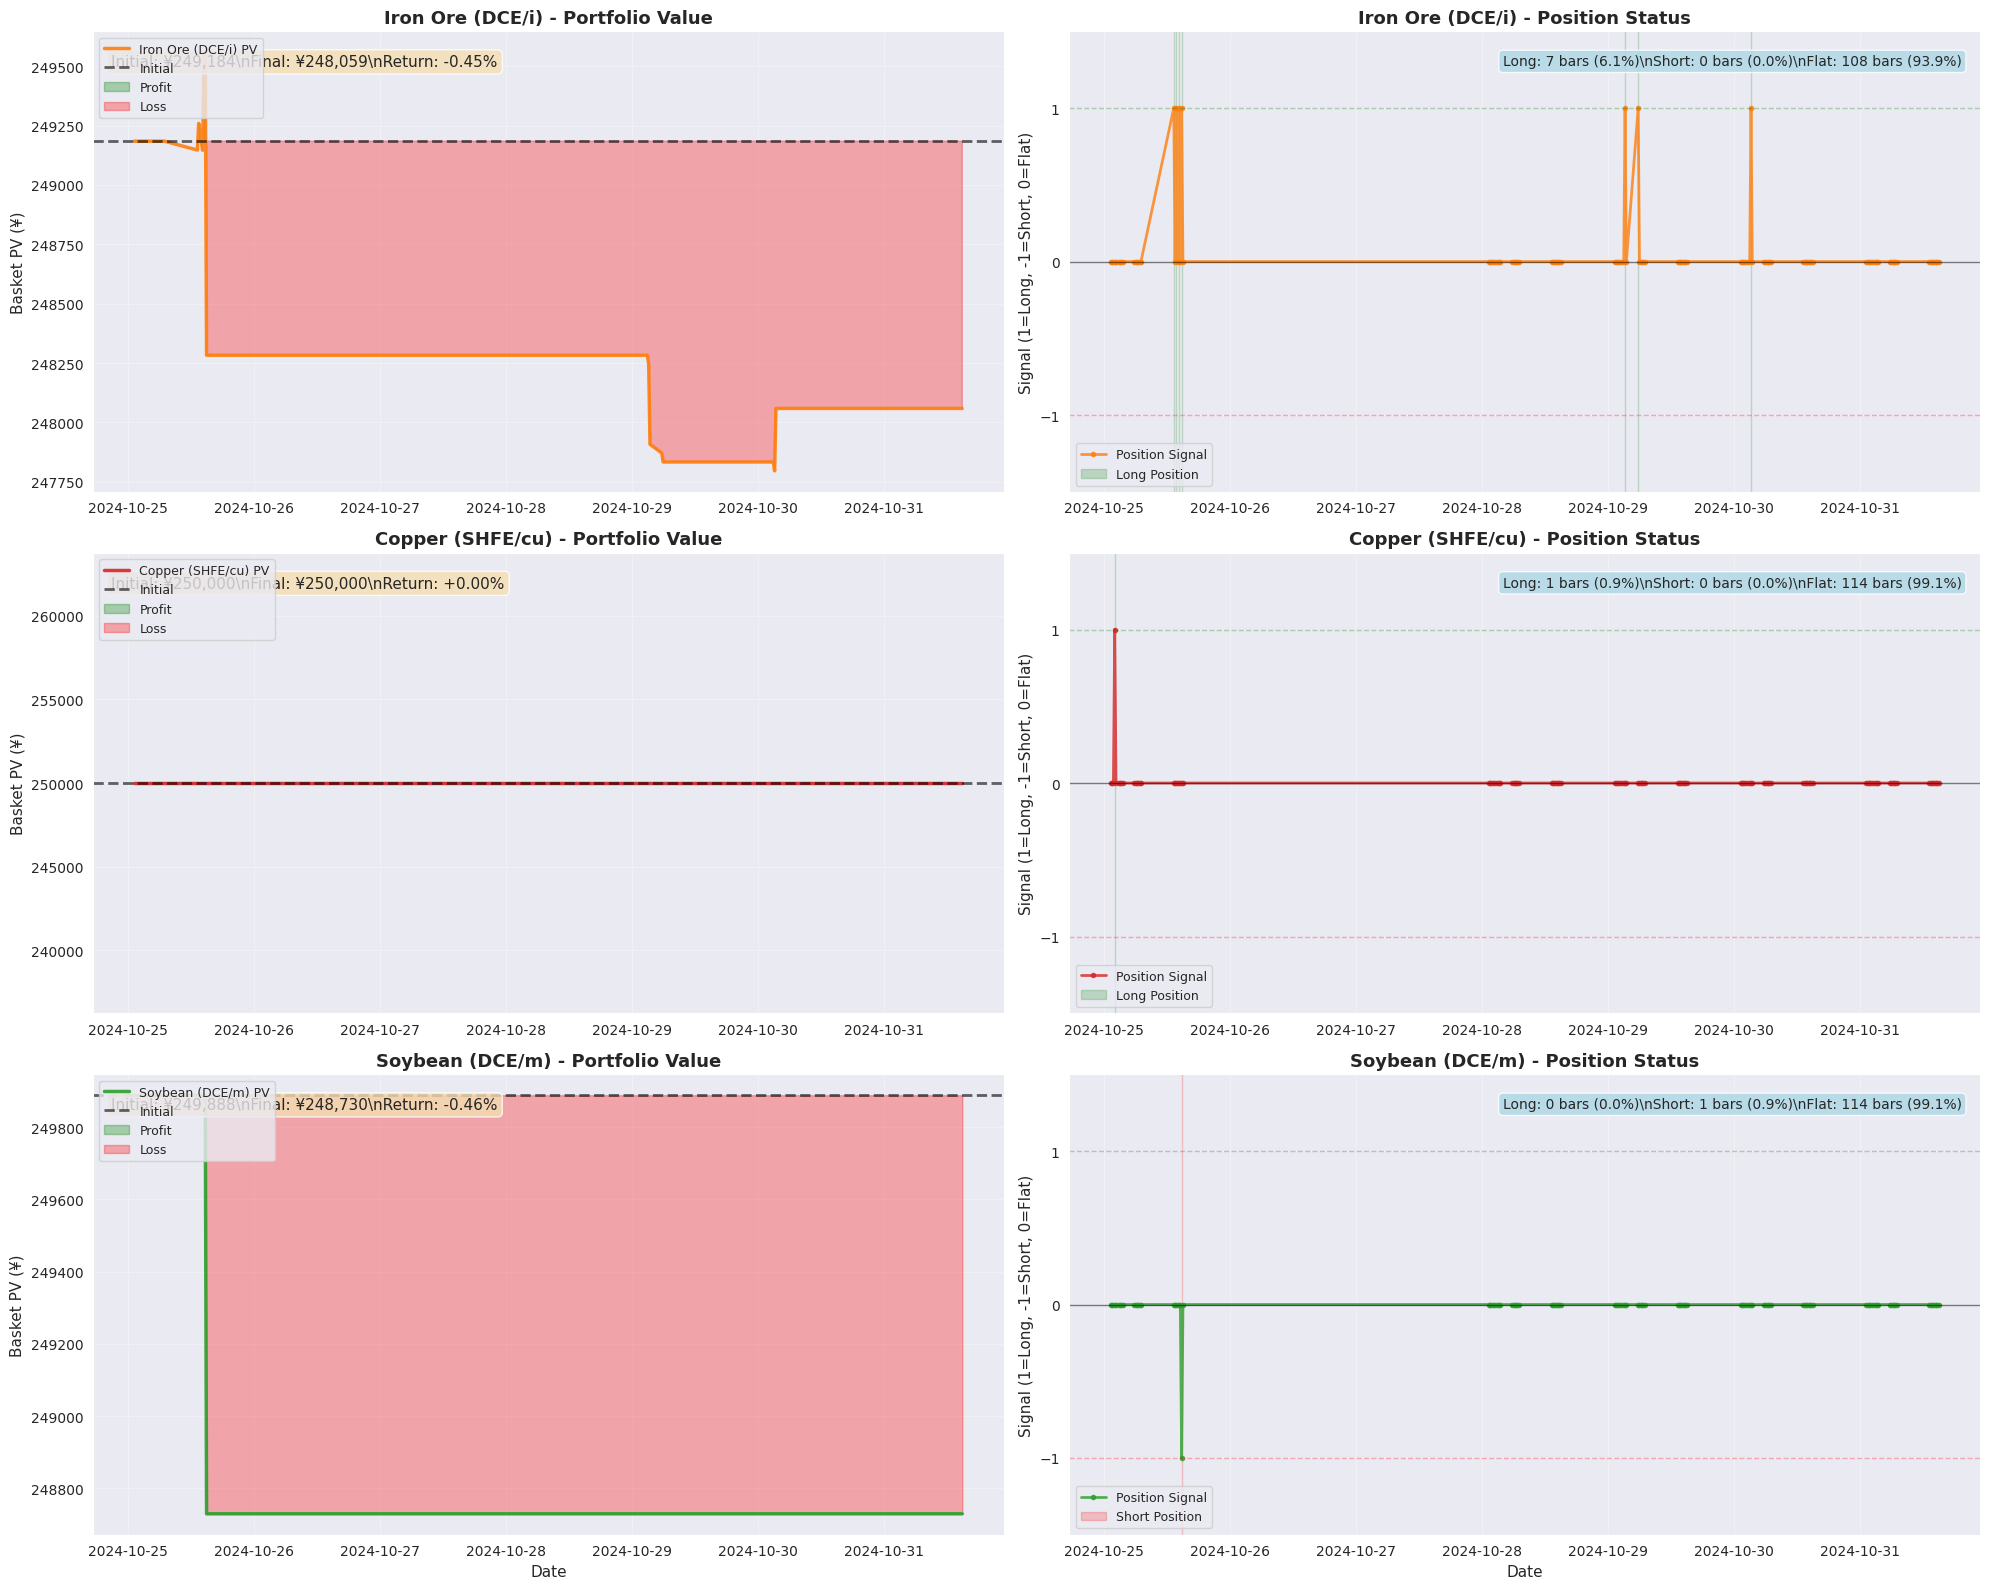

In [59]:
if df_composite is not None and has_basket_data:
    
    fig, axes = plt.subplots(3, 2, figsize=(20, 16))
    
    baskets = [
        ('basket_0', 'Iron Ore (DCE/i)', 'basket_0_pv', 'basket_0_signal', 'basket_0_price', 'tab:orange'),
        ('basket_1', 'Copper (SHFE/cu)', 'basket_1_pv', 'basket_1_signal', 'basket_1_price', 'tab:red'),
        ('basket_2', 'Soybean (DCE/m)', 'basket_2_pv', 'basket_2_signal', 'basket_2_price', 'tab:green')
    ]
    
    for i, (basket_key, name, pv_col, signal_col, price_col, color) in enumerate(baskets):
        
        # Left column: Basket P&L
        ax_left = axes[i, 0]
        
        initial_pv = df_composite[pv_col].iloc[0]
        final_pv = df_composite[pv_col].iloc[-1]
        basket_return = ((final_pv / initial_pv) - 1) * 100 if initial_pv > 0 else 0
        
        ax_left.plot(df_composite['timestamp'], df_composite[pv_col],
                    linewidth=2.5, color=color, label=f'{name} PV', alpha=0.9)
        ax_left.axhline(y=initial_pv, color='black', linestyle='--',
                       alpha=0.6, linewidth=2, label='Initial')
        
        # Fill profit/loss areas
        ax_left.fill_between(df_composite['timestamp'], initial_pv, df_composite[pv_col],
                            where=df_composite[pv_col] >= initial_pv,
                            alpha=0.3, color='green', label='Profit')
        ax_left.fill_between(df_composite['timestamp'], initial_pv, df_composite[pv_col],
                            where=df_composite[pv_col] < initial_pv,
                            alpha=0.3, color='red', label='Loss')
        
        # Add performance stats
        textstr = f'Initial: ¥{initial_pv:,.0f}\\n'
        textstr += f'Final: ¥{final_pv:,.0f}\\n'
        textstr += f'Return: {basket_return:+.2f}%'
        
        ax_left.text(0.02, 0.95, textstr, transform=ax_left.transAxes,
                    fontsize=11, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        ax_left.set_title(f'{name} - Portfolio Value', fontsize=13, fontweight='bold')
        ax_left.set_ylabel('Basket PV (¥)', fontsize=11)
        if i == 2:
            ax_left.set_xlabel('Date', fontsize=11)
        ax_left.legend(loc='upper left', fontsize=9)
        ax_left.grid(True, alpha=0.3)
        
        # Right column: Position Status
        ax_right = axes[i, 1]
        
        # Plot signal/position over time
        ax_right.plot(df_composite['timestamp'], df_composite[signal_col],
                     linewidth=2, color=color, label='Position Signal', alpha=0.8, marker='o', markersize=3)
        
        # Shade position periods
        long_mask = df_composite[signal_col] == 1
        short_mask = df_composite[signal_col] == -1
        
        if long_mask.sum() > 0:
            ax_right.fill_between(df_composite['timestamp'], -1.5, 1.5,
                                 where=long_mask, alpha=0.2, color='green', label='Long Position')
        if short_mask.sum() > 0:
            ax_right.fill_between(df_composite['timestamp'], -1.5, 1.5,
                                 where=short_mask, alpha=0.2, color='red', label='Short Position')
        
        ax_right.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        ax_right.axhline(y=1, color='green', linestyle='--', linewidth=1, alpha=0.3)
        ax_right.axhline(y=-1, color='red', linestyle='--', linewidth=1, alpha=0.3)
        
        # Calculate position stats
        total_bars = len(df_composite)
        long_bars = long_mask.sum()
        short_bars = short_mask.sum()
        flat_bars = total_bars - long_bars - short_bars
        
        stats_text = f'Long: {long_bars} bars ({long_bars/total_bars*100:.1f}%)\\n'
        stats_text += f'Short: {short_bars} bars ({short_bars/total_bars*100:.1f}%)\\n'
        stats_text += f'Flat: {flat_bars} bars ({flat_bars/total_bars*100:.1f}%)'
        
        ax_right.text(0.98, 0.95, stats_text, transform=ax_right.transAxes,
                     fontsize=10, verticalalignment='top', horizontalalignment='right',
                     bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        
        ax_right.set_title(f'{name} - Position Status', fontsize=13, fontweight='bold')
        ax_right.set_ylabel('Signal (1=Long, -1=Short, 0=Flat)', fontsize=11)
        ax_right.set_ylim(-1.5, 1.5)
        ax_right.set_yticks([-1, 0, 1])
        if i == 2:
            ax_right.set_xlabel('Date', fontsize=11)
        ax_right.legend(loc='lower left', fontsize=9)
        ax_right.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('individual_basket_performance.png', dpi=150, bbox_inches='tight')
    print("\\n✅ Individual basket performance chart saved as 'individual_basket_performance.png'")
    plt.show()
    
else:
    print("⚠️ Skipping visualization - basket data not available")

## 12. Basket Allocation Over Time

\n✅ Basket allocation chart saved as 'basket_allocation.png'


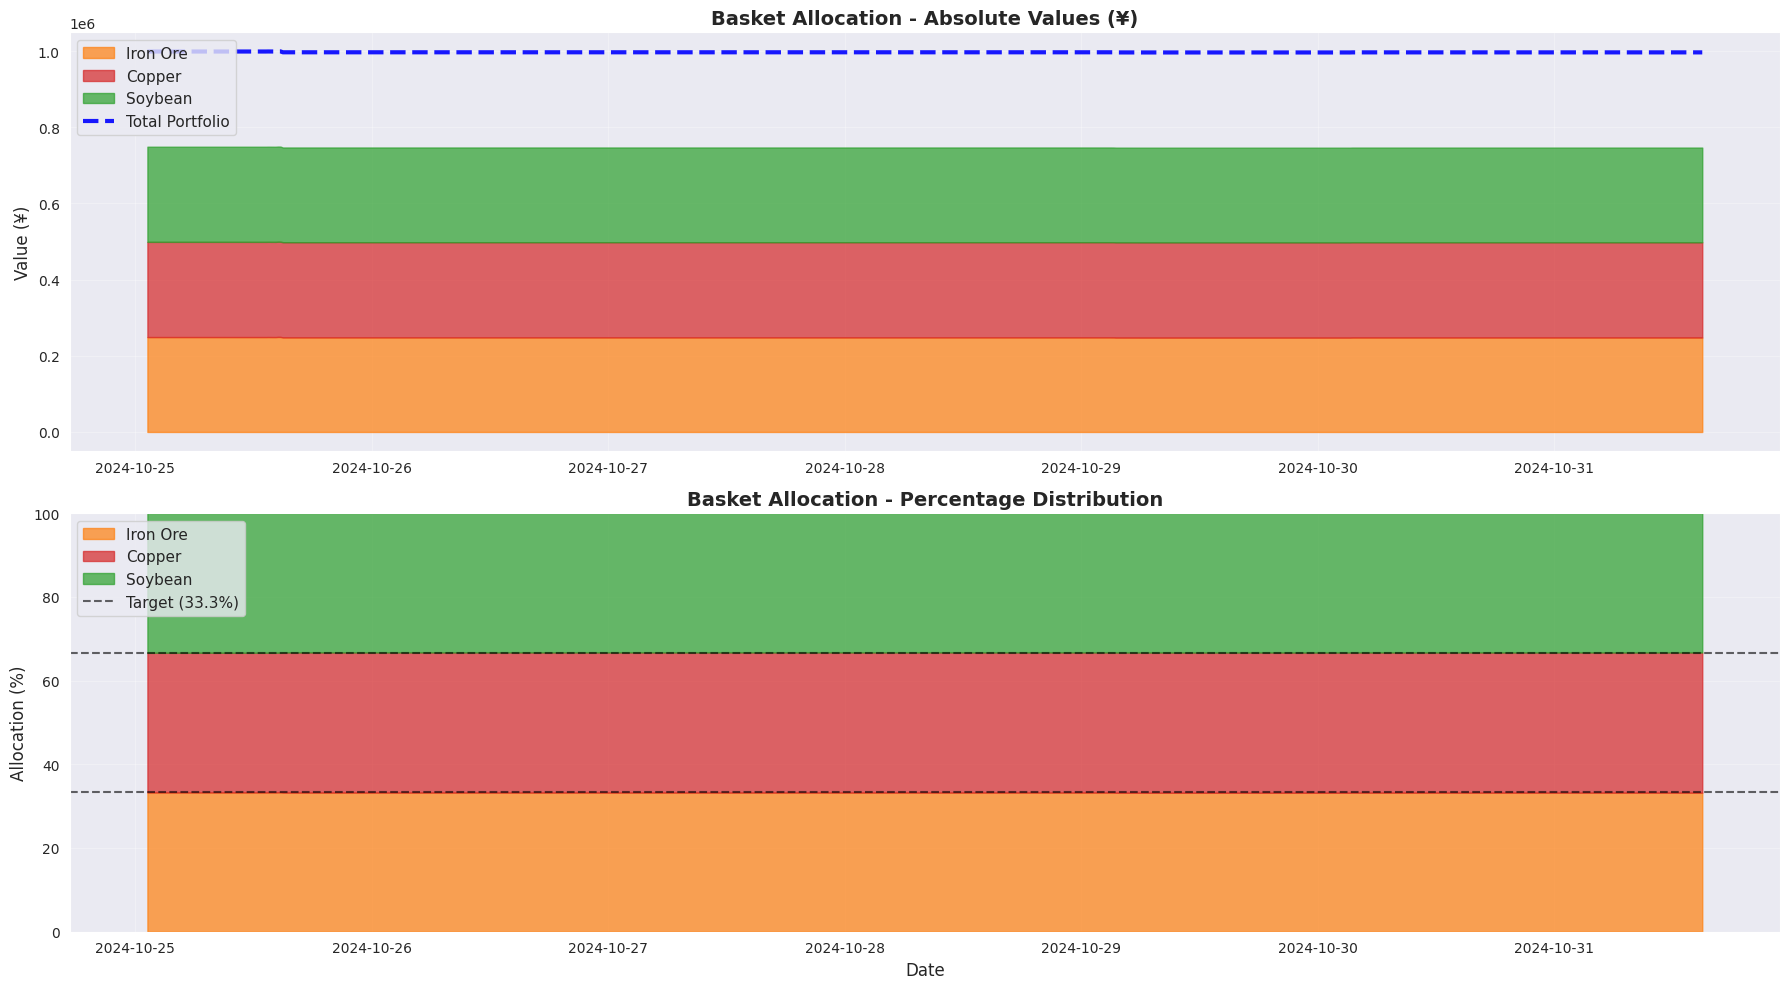

\n======================================================================
BASKET ALLOCATION STATISTICS
Average Allocation:
  Iron Ore (Basket 0): 33.23%
  Copper (Basket 1): 33.46%
  Soybean (Basket 2): 33.32%
\nFinal Allocation:
  Iron Ore (Basket 0): 33.22%
  Copper (Basket 1): 33.48%
  Soybean (Basket 2): 33.31%


In [60]:
if df_composite is not None and has_basket_data:
    
    fig, axes = plt.subplots(2, 1, figsize=(18, 10))
    
    # Panel 1: Stacked Area Chart - Absolute Values
    ax1 = axes[0]
    
    ax1.fill_between(df_composite['timestamp'], 0, df_composite['basket_0_pv'],
                    alpha=0.7, color='tab:orange', label='Iron Ore')
    ax1.fill_between(df_composite['timestamp'],
                    df_composite['basket_0_pv'],
                    df_composite['basket_0_pv'] + df_composite['basket_1_pv'],
                    alpha=0.7, color='tab:red', label='Copper')
    ax1.fill_between(df_composite['timestamp'],
                    df_composite['basket_0_pv'] + df_composite['basket_1_pv'],
                    df_composite['basket_0_pv'] + df_composite['basket_1_pv'] + df_composite['basket_2_pv'],
                    alpha=0.7, color='tab:green', label='Soybean')
    
    # Overlay total PV
    ax1.plot(df_composite['timestamp'], df_composite['pv'],
            linewidth=3, color='blue', label='Total Portfolio', alpha=0.9, linestyle='--')
    
    ax1.set_title('Basket Allocation - Absolute Values (¥)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Value (¥)', fontsize=12)
    ax1.legend(loc='upper left', fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Percentage Allocation
    ax2 = axes[1]
    
    # Calculate percentage allocation
    total_basket_pv = df_composite['basket_0_pv'] + df_composite['basket_1_pv'] + df_composite['basket_2_pv']
    basket_0_pct = (df_composite['basket_0_pv'] / total_basket_pv * 100).fillna(0)
    basket_1_pct = (df_composite['basket_1_pv'] / total_basket_pv * 100).fillna(0)
    basket_2_pct = (df_composite['basket_2_pv'] / total_basket_pv * 100).fillna(0)
    
    ax2.fill_between(df_composite['timestamp'], 0, basket_0_pct,
                    alpha=0.7, color='tab:orange', label='Iron Ore')
    ax2.fill_between(df_composite['timestamp'],
                    basket_0_pct,
                    basket_0_pct + basket_1_pct,
                    alpha=0.7, color='tab:red', label='Copper')
    ax2.fill_between(df_composite['timestamp'],
                    basket_0_pct + basket_1_pct,
                    basket_0_pct + basket_1_pct + basket_2_pct,
                    alpha=0.7, color='tab:green', label='Soybean')
    
    # Target allocation line (33.33%)
    ax2.axhline(y=33.33, color='black', linestyle='--', linewidth=1.5, alpha=0.6, label='Target (33.3%)')
    ax2.axhline(y=66.67, color='black', linestyle='--', linewidth=1.5, alpha=0.6)
    
    ax2.set_title('Basket Allocation - Percentage Distribution', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Allocation (%)', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylim(0, 100)
    ax2.legend(loc='upper left', fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('basket_allocation.png', dpi=150, bbox_inches='tight')
    print("\\n✅ Basket allocation chart saved as 'basket_allocation.png'")
    plt.show()
    
    # Print allocation statistics
    print("\\n" + "="*70)
    print("BASKET ALLOCATION STATISTICS")
    print("="*70)
    
    avg_0 = basket_0_pct.mean()
    avg_1 = basket_1_pct.mean()
    avg_2 = basket_2_pct.mean()
    
    print(f"Average Allocation:")
    print(f"  Iron Ore (Basket 0): {avg_0:.2f}%")
    print(f"  Copper (Basket 1): {avg_1:.2f}%")
    print(f"  Soybean (Basket 2): {avg_2:.2f}%")
    print(f"\\nFinal Allocation:")
    print(f"  Iron Ore (Basket 0): {basket_0_pct.iloc[-1]:.2f}%")
    print(f"  Copper (Basket 1): {basket_1_pct.iloc[-1]:.2f}%")
    print(f"  Soybean (Basket 2): {basket_2_pct.iloc[-1]:.2f}%")
    print("="*70)
    
else:
    print("⚠️ Skipping visualization - basket data not available")

## 13. Basket Performance Comparison

\n======================================================================
BASKET PERFORMANCE COMPARISON


,Basket,Initial Value,Final Value,Return (%),Max DD (%),In Position (%)
0,Iron Ore (Basket 0),"¥249,184.00","¥248,058.69",-0.45%,-0.71%,6.1%
1,Copper (Basket 1),"¥250,000.00","¥250,000.00",+0.00%,0.00%,0.9%
2,Soybean (Basket 2),"¥249,888.00","¥248,729.60",-0.46%,-0.46%,0.9%
3,─────────────────────────,,,,,
4,COMPOSITE PORTFOLIO,"¥999,072.00","¥996,788.29",-0.23%,-0.29%,N/A


\n✅ Basket returns comparison chart saved


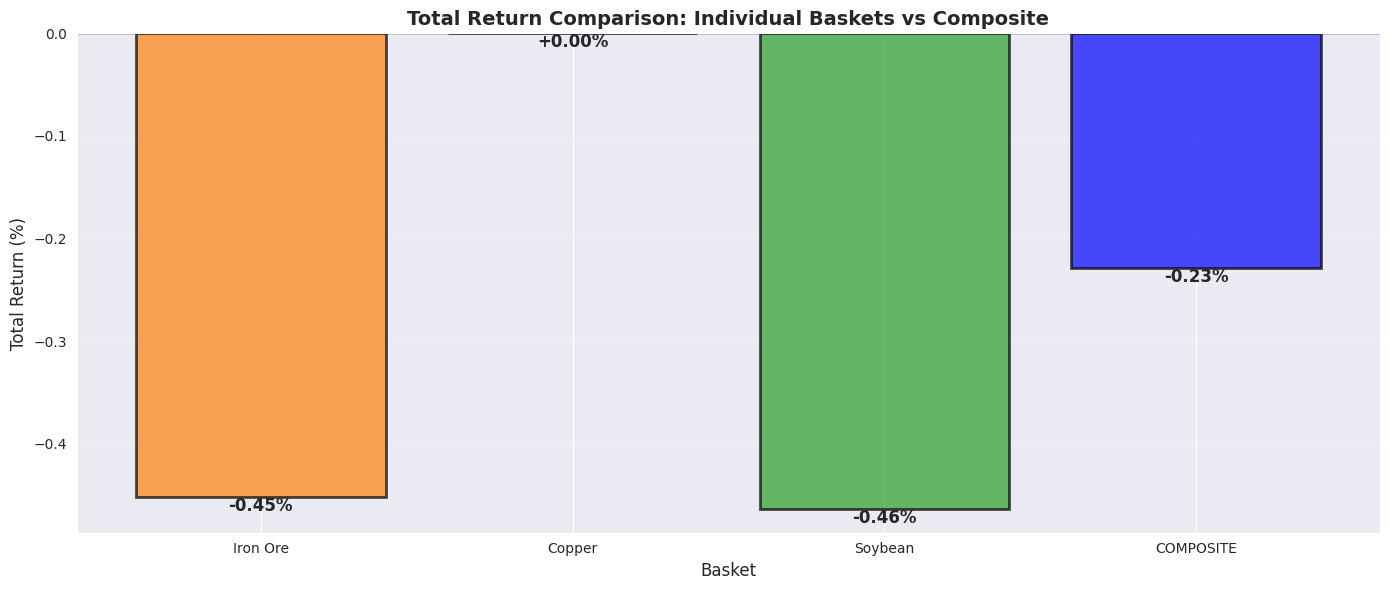

In [61]:
if df_composite is not None and has_basket_data:
    
    print("\\n" + "="*70)
    print("BASKET PERFORMANCE COMPARISON")
    print("="*70)
    
    # Calculate individual basket returns
    baskets_data = [
        ('Iron Ore (Basket 0)', 'basket_0_pv', 'basket_0_signal'),
        ('Copper (Basket 1)', 'basket_1_pv', 'basket_1_signal'),
        ('Soybean (Basket 2)', 'basket_2_pv', 'basket_2_signal')
    ]
    
    comparison_data = []
    
    for name, pv_col, signal_col in baskets_data:
        initial = df_composite[pv_col].iloc[0]
        final = df_composite[pv_col].iloc[-1]
        ret = ((final / initial) - 1) * 100 if initial > 0 else 0
        
        # Calculate drawdown
        cummax = df_composite[pv_col].cummax()
        dd = ((df_composite[pv_col] - cummax) / cummax * 100).min()
        
        # Position time
        total_bars = len(df_composite)
        in_position = (df_composite[signal_col] != 0).sum()
        position_pct = in_position / total_bars * 100
        
        comparison_data.append({
            'Basket': name,
            'Initial Value': f'¥{initial:,.2f}',
            'Final Value': f'¥{final:,.2f}',
            'Return (%)': f'{ret:+.2f}%',
            'Max DD (%)': f'{dd:.2f}%',
            'In Position (%)': f'{position_pct:.1f}%'
        })
    
    # Add composite for comparison
    comp_initial = df_composite['pv'].iloc[0]
    comp_final = df_composite['pv'].iloc[-1]
    comp_ret = ((comp_final / comp_initial) - 1) * 100
    comp_dd = ((df_composite['pv'] - df_composite['pv'].cummax()) / df_composite['pv'].cummax() * 100).min()
    
    comparison_data.append({
        'Basket': '─' * 25,
        'Initial Value': '',
        'Final Value': '',
        'Return (%)': '',
        'Max DD (%)': '',
        'In Position (%)': ''
    })
    
    comparison_data.append({
        'Basket': 'COMPOSITE PORTFOLIO',
        'Initial Value': f'¥{comp_initial:,.2f}',
        'Final Value': f'¥{comp_final:,.2f}',
        'Return (%)': f'{comp_ret:+.2f}%',
        'Max DD (%)': f'{comp_dd:.2f}%',
        'In Position (%)': 'N/A'
    })
    
    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df)
    
    # Bar chart comparison
    fig, ax = plt.subplots(figsize=(14, 6))
    
    basket_names = ['Iron Ore', 'Copper', 'Soybean', 'COMPOSITE']
    basket_returns = [
        ((df_composite['basket_0_pv'].iloc[-1] / df_composite['basket_0_pv'].iloc[0]) - 1) * 100,
        ((df_composite['basket_1_pv'].iloc[-1] / df_composite['basket_1_pv'].iloc[0]) - 1) * 100,
        ((df_composite['basket_2_pv'].iloc[-1] / df_composite['basket_2_pv'].iloc[0]) - 1) * 100,
        comp_ret
    ]
    basket_colors = ['tab:orange', 'tab:red', 'tab:green', 'blue']
    
    bars = ax.bar(basket_names, basket_returns, color=basket_colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    # Add value labels
    for bar, val in zip(bars, basket_returns):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{val:+.2f}%', ha='center',
               va='bottom' if val > 0 else 'top', fontsize=12, fontweight='bold')
    
    ax.set_title('Total Return Comparison: Individual Baskets vs Composite', fontsize=14, fontweight='bold')
    ax.set_ylabel('Total Return (%)', fontsize=12)
    ax.set_xlabel('Basket', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('basket_returns_comparison.png', dpi=150, bbox_inches='tight')
    print("\\n✅ Basket returns comparison chart saved")
    plt.show()
    
    print("="*70)
    
else:
    print("⚠️ Skipping comparison - basket data not available")

## 14. Summary

This notebook provides comprehensive analysis of the Tier-2 Composite Strategy:

### Portfolio-Level Analysis:
1. Portfolio Value (PV) tracking
2. Net Value (NV) performance ratio
3. Active positions monitoring
4. Portfolio allocation (exposure vs cash)
5. Drawdown analysis
6. Monthly performance breakdown
7. Risk compliance validation

### Basket-Level Analysis (NEW):
8. Individual basket P&L curves
9. Per-basket position status over time
10. Basket allocation (absolute and percentage)
11. Performance comparison: baskets vs composite

### Key Insights:
- **Diversification**: See how individual baskets contribute to portfolio stability
- **Attribution**: Identify which instruments drive returns
- **Risk**: Individual basket drawdowns vs composite drawdown
- **Allocation**: Monitor capital distribution across instruments

### Files Generated:
1. `composite_portfolio_performance.png` - Main portfolio charts
2. `drawdown_analysis.png` - Portfolio drawdown
3. `monthly_performance.png` - Monthly breakdown
4. `individual_basket_performance.png` - Per-basket P&L and positions ⭐ **NEW**
5. `basket_allocation.png` - Capital allocation over time ⭐ **NEW**
6. `basket_returns_comparison.png` - Returns comparison ⭐ **NEW**

---

**Note**: If basket-level data is not available, re-run the strategy after the CompositeStrategy.py and uout.json updates.

## 10. Summary

This notebook provides comprehensive analysis of the Tier-2 Composite Strategy performance:

### Key Metrics Tracked:
1. **Portfolio Value (PV)** - Total portfolio worth over time
2. **Net Value (NV)** - Performance ratio (PV / Initial Capital)
3. **Active Positions** - Number of instruments actively traded (0-3)
4. **Portfolio Exposure** - Percentage of capital invested
5. **Cash Reserve** - Percentage of capital in cash
6. **Drawdown** - Peak-to-trough decline tracking
7. **Monthly Returns** - Month-over-month performance

### Risk Compliance:
- Max Drawdown: ≤ 10%
- Max Exposure: ≤ 90%
- Min Cash Reserve: ≥ 15%
- All limits validated in section 7

### Files Generated:
1. Visualization charts (PNG)
2. Portfolio data (CSV)
3. Performance metrics (CSV)
4. Monthly summary (CSV)

### Strategy Evaluation:
- Sharpe Ratio target: > 1.0
- Positive return requirement
- Risk limit compliance
- Monthly win rate analysis

---

**For Questions**: Refer to TIER2_COMPOSITE_STRATEGY_REQUIREMENTS.md for complete specifications.